<a href="https://colab.research.google.com/github/dudeurv/SAM_MRI/blob/main/Basic_SAM_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Image Segmentation with SAM Models

**SAM with 'vit_b' Configuration:**


This version of SAM includes 12 multihead attention (MHA) blocks.
MHAs allow the model to focus on distinct segments of an image, making the 'vit_b' model well-suited for general segmentation tasks.

Model Download Link: !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

**SAM with 'vit_l' Configuration:**

The 'vit_l' model is more advanced, comprising 24 MHA blocks.
It is designed for more complex images, where detailed and refined segmentation is needed.

Model Download Link: !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth

**SAM with 'vit_h' Configuration:**

The 'vit_h' configuration is the most sophisticated among the three, equipped with 32 MHA blocks.
It excels in segmenting highly complex images with intricate details.

Model Download Link: !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


**Customizing or debugging the SAM models:**

You can edit the source code in the following files within the SAM library:

For the Image Encoder: /usr/local/lib/python3.10/dist-packages/segment_anything/modeling/image_encoder.py
For the SAM Model itself: /usr/local/lib/python3.10/dist-packages/segment_anything/modeling/sam.py

# 1) Download Image and SAM Model

In [3]:
import gdown

# Download a specific image for testing using gdown
import gdown
url = 'https://drive.google.com/uc?id=1ycUjt29WI4VjK6grZnQXYdzdEuMhpqNA'
gdown.download(url, 'raw_img.jpg', quiet=True)

# Install the SAM library from Facebook Research
!pip -q install 'git+https://github.com/facebookresearch/segment-anything.git'

# Download the pre-trained SAM model for the 'vit_b' configuration
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

  Preparing metadata (setup.py) ... done
--2023-11-23 00:46:19--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.114, 52.84.251.106, 52.84.251.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth.1’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   221MB/s    in 1.6s    

2023-11-23 00:46:21 (221 MB/s) - ‘sam_vit_b_01ec64.pth.1’ saved [375042383/375042383]



# 2) Setting up SAM & Segmenting Image

In [4]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
import numpy as np


# Check if CUDA (GPU support) is available for PyTorch, use CPU otherwise
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the SAM model with the specified model type and checkpoint, set it to the selected device
sam = sam_model_registry["vit_b"](checkpoint="/content/sam_vit_b_01ec64.pth").to(device)

# Initialize the automatic mask generator with the SAM model
mask_generator = SamAutomaticMaskGenerator(sam)

# Load the downloaded image using PIL and convert it to a numpy array
raw_img = Image.open('/content/raw_img.jpg')
image = np.array(raw_img)

# Generate segmentation masks for the image using the SAM model
masks = mask_generator.generate(image)

# Print the structure of the first mask to understand its format
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


# 3) Visualise Results

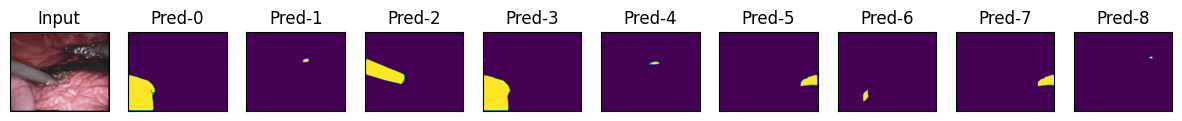

In [5]:
import matplotlib.pyplot as plt

num_img = len(masks)
num_img = 10
fig, ax = plt.subplots(1, num_img, figsize=(1.5*num_img,7), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(image)
ax[0].set_title('Input')
for i in range(num_img - 1):
    ax[i+1].imshow(masks[i]['segmentation'])
    ax[i+1].set_title('Pred-{}'.format(i))

# 4) Further options

# Using the SAM Encoder for Downstream Tasks

The encoder part of the SAM model processes the image and extracts a high-level representation or features from it.

**Output:** Instead of segmentation masks, the encoder's output is a feature map or a tensor that encapsulates the important aspects of the image in a more abstract form.

**What is the purpose of this?**

**Downstream Machine Learning Tasks:** Such as input to other models for classification, clustering, or further analysis.

**Reducing Image Complexity:** Simplifying images into a form that's easier to analyze or process.

**Transfer Learning:** Using the learned features in one context and applying them to another problem or model.

In [9]:
# Import the transforms module from torchvision
from torchvision import transforms

def main():
    # Access the SAM model's image encoder
    sam_encoder = sam.image_encoder

    # Apply the transformations to the image and move it to CUDA if available
    img = preprocess(raw_img)[None].cuda()

    # Pass the transformed image through the SAM encoder
    encoder_out = sam_encoder(img)
    print(encoder_out.shape)

def preprocess(the_image):
    # Define the mean and standard deviation for normalization (to standardize the values of an image's pixels)
    # These specific values are standard in image processing, often used for models trained on the ImageNet dataset.
    mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])

    # Define the transformation pipeline for the image
    transform = transforms.Compose([transforms.Resize((1024, 1024)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mean, std=std)])
    return transform(the_image)

# Execute the main function
main()

torch.Size([1, 256, 64, 64])
